# Studies of data reuse: Excitability profile of CA1 pyramidal neurons in APPPS1 Alzheimer disease mice and control littermates

**Isaure Botherel and Andrew P. Davison**

Paris-Saclay Institute of Neuroscience, CNRS, Université Paris-Saclay, France.

October 2023

----

In this notebook we will look more closely at the EBRAINS dataset "[Excitability profile of CA1 pyramidal neurons in APPPS1 Alzheimer disease mice and control littermates (v1)](https://search.kg.ebrains.eu/#bd5f91ff-e829-4b85-92eb-fc56991541f1)", contributed by Ana Rita Salgueiro-Pereira and Hélène Marie from the Université Côte d’Azur in Valbonne, France.

As we can see from the dataset description,

<i>This dataset provides an analysis of the intrinsic electrophysiological properties of CA1 excitatory hippocampal
neurons in a mouse model of Alzheimer’s Disease (AD) at two age points: a presymptomatic age (3-4
months) and a symptomatic age: (9-10 months).</i>
More information is available in the [Data Descriptor](https://search.kg.ebrains.eu/instances/bd5f91ff-e829-4b85-92eb-fc56991541f1).

This dataset forms part of the results reported in Vitale, P., Salgueiro-Pereira, A. R., Lupascu, C. A., Willem, M., Migliore, R., Migliore, M., & Marie, H.(2021) Analysis of Age-Dependent Alterations in Excitability Properties of CA1 Pyramidal Neurons in an APPPS1 Model of Alzheimer’s Disease. *Frontiers in Aging Neuroscience* **13** https://doi.org/10.3389/fnagi.2021.668948

In this notebook we will demonstrate how to access the data files and the metadata from this study, and how these data can be analysed and visualised, with the goal of reproducing some of the figures from the article. 

## Downloading the data

Please note that this is a 91 MB dataset. Over a slow connection, this could take a long time to download. If running this notebook on a shared resource such as the EBRAINS lab, you may need to delete the downloaded data after use, to avoid taking up too much disk space.

To download the data, we first search for the dataset in the EBRAINS Knowledge Graph using the [fairgraph](https://fairgraph.readthedocs.io/) tool, then download a zip file, and unzip it.

In [1]:
import os
import zipfile
from fairgraph import KGClient
import fairgraph.openminds.core as omcore
from fairgraph.openminds.core import DatasetVersion
import json

client = KGClient(host="core.kg.ebrains.eu", token=clb_oauth.get_token())
if not os.path.exists("downloads"):
    dataset = omcore.Dataset.by_name("Excitability profile of CA1 pyramidal neurons in APPPS1 Alzheimer disease mice and control littermates", client)
    dataset_version = dataset.versions.resolve(client)
    
    dataset_path = dataset_version.download("downloads", client, accept_terms_of_use=True)
    
with zipfile.ZipFile("downloads/ext-d000001_ADNeuronModel_pub.zip", "r") as z:
    z.extractall("downloads")

## Retrieve the Metadata


In [ ]:
metadata = omcore.Configuration.from_id("6d6b4f64-a9e1-47a5-9a90-7801b9421fc1", client, scope="any")
print(json.loads(metadata.configuration))

current_pulse_amplitudes = json.loads(metadata.configuration)["amplitudes"]
onset = json.loads(metadata.configuration)["onset"]
duration = json.loads(metadata.configuration)["duration"]
interval = json.loads(metadata.configuration)["interval"]

onset = onset/1000
duration = duration/1000
interval = interval/1000

## Exploring and visualizing the data

The data are organized into four folders, "APPPS1_mouse_model_3-4_months", "control_3-4_months", "APPPS1_mouse_model_9-10_months", "control_9-10_months", each of which contains a number of files with the extension ".abf".

It should be noted that the dataset does not contain the data for mice at age 1 month that are shown in the associated paper (Vitale et al., 2021).

We know from the dataset metadata that these are electrophysiology data, and more specifically that they were obtained with the whole cell patch clamp technique in current clamp mode. We will therefore use the [Neo library](https://neo.readthedocs.io/) to read the data files, since it is able to read data from a large number of electrophysiology file formats.

In [4]:
from glob import glob
import numpy as np
from neo import get_io

Neo loads data into a hierarchical structure: Blocks contain Segments, which contain the actual data.

Let's look at the structure of the first three files:

In [5]:
for file_path in glob("downloads/*/*.abf")[:3]:
    io = get_io(file_path)
    print(io)

AxonIO: downloads/APPPS1_mouse_model_3-4_months/191129000_S23.abf
nb_block: 1
nb_segment:  [13]
signal_streams: [Signals (chans: 1)]
signal_channels: [IN0]
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/APPPS1_mouse_model_3-4_months/191129002_S23.abf
nb_block: 1
nb_segment:  [13]
signal_streams: [Signals (chans: 1)]
signal_channels: [IN0]
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/APPPS1_mouse_model_3-4_months/191129003_S23.abf
nb_block: 1
nb_segment:  [13]
signal_streams: [Signals (chans: 1)]
signal_channels: [IN0]
spike_channels: []
event_channels: [Tag]



These all have a consistent structure: they're in Axon format, contain a single block containing 13 segments, and each segment contains a single recorded signal containing a single channel. 
We know from the associated paper that current pulses of increasing intensity were injected into the neurons, in steps of 50 pA from -200 to 400 pA.

In [6]:
print(current_pulse_amplitudes)
print(f"Number of current pulses: {len(current_pulse_amplitudes)}")

[-200 -150 -100  -50    0   50  100  150  200  250  300  350  400]
Number of current pulses: 13


So it seems likely that each segment contains the response to one current pulse. We will assume at this point that all the signals are similar, and take a closer look at one of them.

In [7]:
data = get_io("downloads/APPPS1_mouse_model_3-4_months/191129000_S23.abf").read(lazy=True)
example_signal = data[0].segments[0].analogsignals[0].load()
example_signal

AnalogSignal with 1 channels of length 50000; units mV; datatype float32 
name: 'Signals'
annotations: {'stream_id': '0'}
sampling rate: 10000.0 Hz
time: 0.020999999999999998 s to 5.021 s

Now let's plot the data from one of the files:

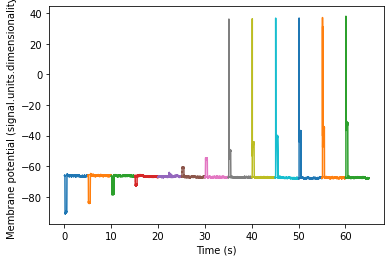

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_data(file_path):
    data = get_io(file_path).read(lazy=True)
    for segment in data[0].segments:
        signal = segment.analogsignals[0].load()
        plt.plot(signal.times, signal)
    plt.xlabel(f"Time ({signal.times.units.dimensionality})")
    plt.ylabel(f"Membrane potential ({signal.units.dimensionality})")

plot_data("downloads/APPPS1_mouse_model_3-4_months/191129000_S23.abf")

To get a closer look at the signals, we can shift the time axis to be relative to the start time of each signal, and plot only the 500 ms around the current injection:

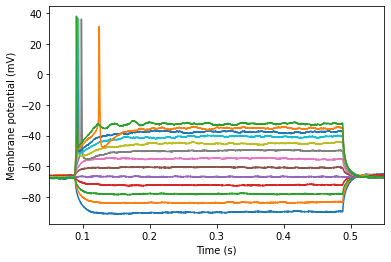

In [9]:
def plot_data_zoom(file_path):
    data = get_io(file_path).read(lazy=True)
    for segment in data[0].segments:
        signal = segment.analogsignals[0].load()
        plt.plot(signal.times - signal.t_start, signal)
    marge = onset * 0.1
    plt.xlim(onset - marge, interval/10 + marge)
    plt.xlabel(f"Time ({signal.times.units.dimensionality})")
    plt.ylabel(f"Membrane potential ({signal.units.dimensionality})")

plot_data_zoom("downloads/APPPS1_mouse_model_3-4_months/191129000_S23.abf")

### Plotting utilities

To save code later, we'll define a few functions to change the appearance of our plots.

In [10]:
def hide_axes(axes, hide=["top", "bottom", "right", "left"]):
    for ax in axes:
        if "bottom" in hide:
            ax.set_xticks([])
        if "left" in hide:
            ax.set_yticks([])
        for spine in hide:
            ax.spines[spine].set_visible(False)

### Figure 2

Figure 2A shows the input resistance calculated from the native resting membrane potential (RMP) of the neuron (i.e. the resting membrane potential *before* a holding current is injected to bring it to -65 mV), and Figure 2B shows the native RMP.
The files in the dataset only contain data recorded *while* the holding current is being injected, so we cannot reproduce panels 2A and 2B.

The remainder of Figure 2 show calculations of the membrane time constant, based on the responses to current injection. According to the paper, "The membrane time constant was calculated for different negative current injections (–200, –150, –100, and –50 pA) by fitting the first part of the membrane potential, from the start of the current injection up to the peak of the sag" with the function *A + B exp(-t/tau)*.

Next we define some functions to implement this fitting procedure:

In [11]:
from scipy.optimize import curve_fit

t_stim_onset = onset * second

def func(t, A, B, tau):
    """The function to fit to the data."""
    return A + B * np.exp(-t / tau)

def fit_to_peak(fragment):
    """Fit an exponential curve to a fragment of the signal."""
    # initial guess for the parameters
    p0 = ( -85, 20, 0.01)  
    # convert Neo signals to plain NumPy arrays
    xdata = (fragment.times - fragment.t_start).magnitude  
    ydata = fragment.magnitude.flatten()
    # fit curve using SciPy
    popt, pcov = curve_fit(func, xdata, ydata, p0)
    return popt

def extract_fragment(signal):
    """Cut out a fragment of the signal, from the start 
    of current injection up to the peak of the sag."""
    # Here we use a really simple algorithm, which assumes that
    # the 'peak' of the sag is the minimum of the signal. 
    # A more robust approach might use the derivative of the signal.
    t_peak_sag = signal.times[signal.argmin()]
    fragment = signal.time_slice(t_stim_onset + signal.t_start, t_peak_sag)
    if fragment.size == 0:
        raise Exception(f"Couldn't extract fragment for {signal.file_origin}. t_peak_sag = {t_peak_sag}")
    return fragment

def get_time_constants_scipy(signals, with_plot=None):
    """
    For a list of signals, fit exponential curves to the first part of each 
    signal, from the start of the current injection up to the peak of the sag,
    and return a list of exponential time constants.

    `with_plot` is an optional array of matplotlib Axes.
    """
    results = []
    for i, signal in enumerate(signals):
        fragment = extract_fragment(signal)
        curve_parameters = fit_to_peak(fragment)
        results.append(curve_parameters[2] * 1000)  # seconds -> ms
        if with_plot is not None:
            # to check that the fitting has worked well, we can
            # optionally plot the data and fitted curves
            if isinstance(with_plot, np.ndarray):
                ax = with_plot[i]
            else:
                ax = with_plot
            t = fragment.times - fragment.t_start
            ax.plot(t, fragment, 'k-')
            ax.plot(t, func(t.magnitude, *curve_parameters), 'r-')
    return results


Now we can apply these fitting functions to our data.

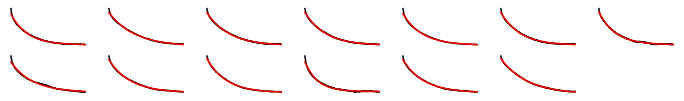

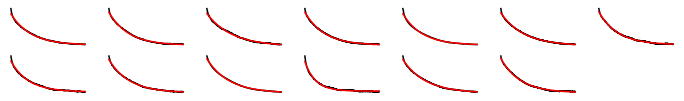

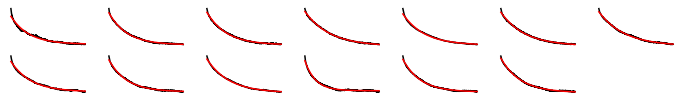

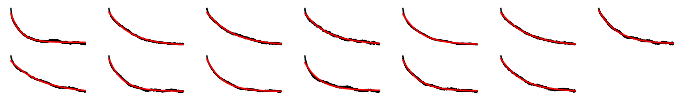

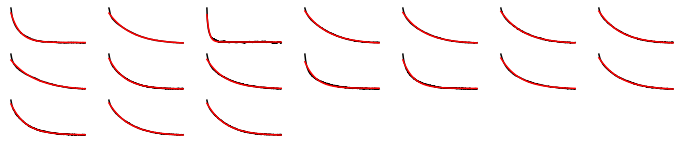

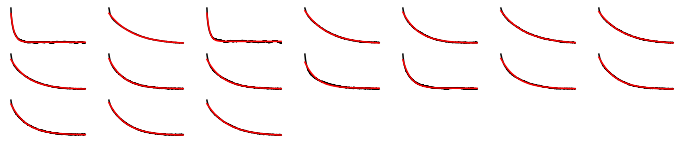

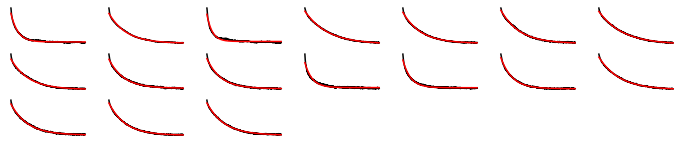

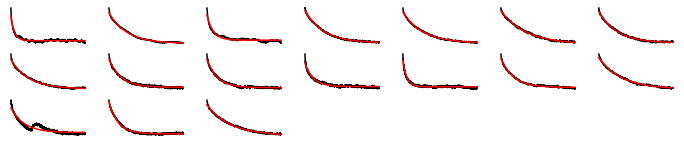

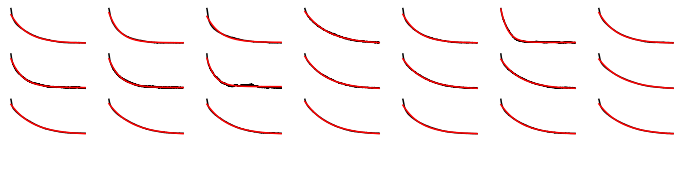

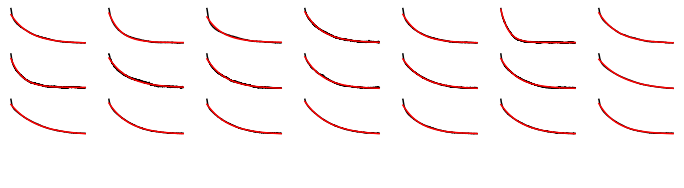

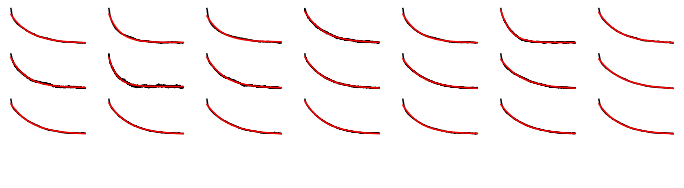

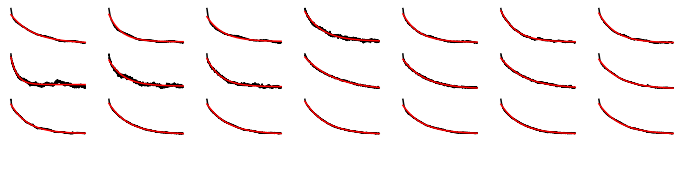

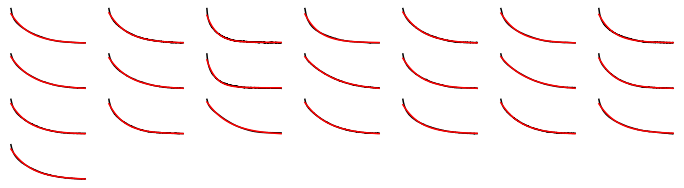

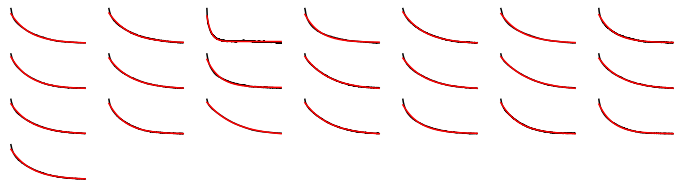

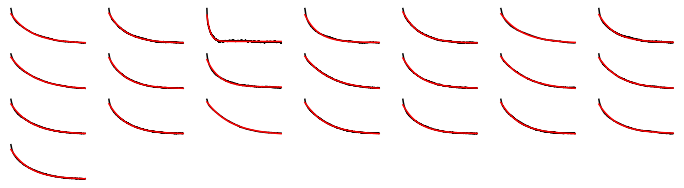

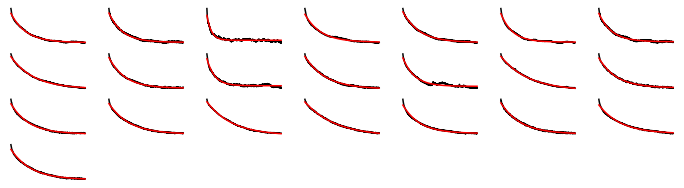

In [12]:
from quantities import second

condition_data = {
    "WT-4m": "control_3-4_months",
    "AD-4m": "APPPS1_mouse_model_3-4_months",
    "WT-10m": "control_9-10_months",
    "AD-10m": "APPPS1_mouse_model_9-10_months",
}

time_constants = {}
for condition_label, data_folder in condition_data.items():
    time_constants[condition_label] = {}
    for injected_current in current_pulse_amplitudes [:4]:
        signals = []
        file_paths = glob(f"downloads/{data_folder}/*.abf")
        for file_path in file_paths:
            data = get_io(file_path).read(lazy=True)
            i = list(current_pulse_amplitudes).index(injected_current)
            signals.append(data[0].segments[i].analogsignals[0].load())

        n_rows = len(file_paths)//7 + 1
        fig, axes = plt.subplots(n_rows, 7, figsize=(12, 0.8 * n_rows))        
        time_constants[condition_label][injected_current] = get_time_constants_scipy(signals, with_plot=axes.ravel())
        hide_axes(axes.ravel())

We can see that the curve fitting has mostly worked well, but there is at least one example where the simple algorithm to find the peak of the sag has not worked.

### Fig 2E

The dataset doesn't contain the recordings for 1-month-old mice, but we can try to reproduce the panels for the older mice.

In [13]:
currents = current_pulse_amplitudes [:4]
data = {
    "4m": [
        time_constants[condition][current]
        for current in currents 
        for condition in ("WT-4m", "AD-4m")
    ],
    "10m": [
        time_constants[condition][current]
        for current in currents 
        for condition in ("WT-10m", "AD-10m")
    ]
}

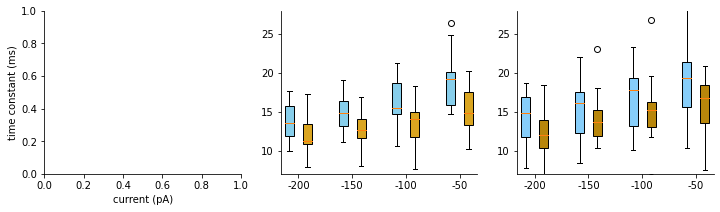

In [14]:
colors = [(), ("skyblue", "goldenrod"), ("lightskyblue", "darkgoldenrod")]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, age in enumerate(("1m", "4m", "10m")):
    ax = axes[i]
    if age in data:
        data_items = data[age]
        bplot = ax.boxplot(data_items, positions=[1, 2, 4, 5, 7, 8, 10, 11], patch_artist=True)
        for j, patch in enumerate(bplot["boxes"]):
            patch.set_facecolor(colors[i][j % 2])
        ax.set_ylim(7, 28)
        ax.set_xticks([1.5, 4.5, 7.5, 10.5], labels=currents)
    if i == 0:
        hide_axes([ax], ["right", "top"])
        ax.set_ylabel("time constant (ms)")
        ax.set_xlabel("current (pA)")
    else:
        hide_axes([ax], ["right", "top"])

Here is the original Figure 2E for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article). We can see that there are numerical differences, probably because of differences in the algorithm for finding the time constants, but the qualitative result is the same.

![fig2e](original_fig2E.png "Original Figure 2E")                                                                               

### Figure 3C
Comparison between Control and AD conditions for mice aged 3–4 months.

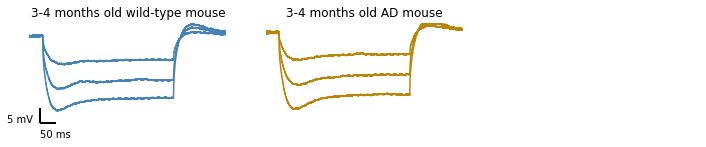

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 2))

file_paths = (
    "downloads/control_3-4_months/191129004_S24.abf",
    "downloads/APPPS1_mouse_model_3-4_months/191129002_S23.abf"
)
titles = (
    "3-4 months old wild-type mouse", "3-4 months old AD mouse"
)
colors = ('steelblue', 'darkgoldenrod')

for file_path, ax, color, title in zip(file_paths, axes[:2], colors, titles):
    data = get_io(file_path).read(lazy=True)[0]
    
    for injected_current in current_pulse_amplitudes[1:4]:
        i = list(current_pulse_amplitudes).index(injected_current)
        signal = data.segments[i].analogsignals[0].load()
        ax.plot(signal.times - signal.t_start, signal, label=f"{injected_current} pA", c=color)

        ax.set_xlim(0.048, 0.65)
        ax.set_ylim(-96, -60)
        #ax.set_xlabel(f"Time ({signal.times.units.dimensionality.string})")
        #ax.set_ylabel(f"Membrane potential ({signal.units.dimensionality.string})")
        ax.set_title(title)
            
hide_axes(axes)

def show_scalebar(ax, loc, deltas, labels):
    sb0 = loc
    dx, dy = deltas
    l1 = [sb0, (sb0[0] + dx, sb0[1])]
    l2 = [sb0, (sb0[0], sb0[1] + dy)]
    scale_bar = LineCollection([l1, l2], color="k", lw=2)
    ax.add_collection(scale_bar)
    ax.text(sb0[0], sb0[1] - dy, labels[0])
    ax.text(sb0[0] - 2 * dx, sb0[1], labels[1])
    
show_scalebar(axes[0], (0.08, -93), (0.05, 5), ("50 ms", "5 mV"))

[Original Figure 3C for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article)]

![fig3c](original_fig3C.jpg "Original Figure 3C")          

### Figure 3D
Comparison between Control and AD conditions for mice aged 9–10 months

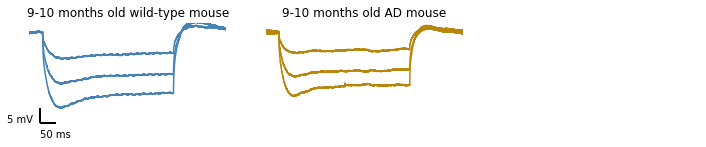

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 2))

file_paths = (
    "downloads/control_9-10_months/191113002_S75.abf",
    "downloads/APPPS1_mouse_model_9-10_months/200120009_S87.abf"
)
titles = (
    "9-10 months old wild-type mouse", "9-10 months old AD mouse"
)
colors = ('steelblue', 'darkgoldenrod')

for file_path, ax, color, title in zip(file_paths, axes[:2], colors, titles):
    data = get_io(file_path).read(lazy=True)[0]
    
    for injected_current in current_pulse_amplitudes[1:4]:
        i = list(current_pulse_amplitudes).index(injected_current)
        signal = data.segments[i].analogsignals[0].load()
        ax.plot(signal.times - signal.t_start, signal, label=f"{injected_current} pA", c=color)

        ax.set_xlim(0.048, 0.65)
        ax.set_ylim(-96, -60)
        ax.set_title(title)
            
hide_axes(axes)    
show_scalebar(axes[0], (0.08, -93), (0.05, 5), ("50 ms", "5 mV"))

[Original Figure 3D for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article)]

![fig3c](original_fig3D.jpg "Original Figure 3D")       

## Summary

In this notebook, we have demonstrated how to access the dataset, and how to read the data files. We have partially reproduced some of the figures from a published paper to which the data contributed.

We leave reproduction of some of the other figures from the paper as an exercise for the reader.